# Code for writing the lung sound data to .ts file

Below is the code for writing the tromsø dataset to .ts files

In [2]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from scipy.stats import skew 

sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis

from time import time
import sys
import os
figure_path = module_path + '/figures/'

sys.path.insert(1, module_path + '/src/')

from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 8000

import os
names = []
#files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
files_path = '/home/andrine/Desktop/dataTromsoFiltered/allFilteres/'
names_full = os.listdir(files_path)
for n in names_full:
    if '_lungelyd_' in n:
        names.append(n)
        
X = pd.read_stata('/home/andrine/Desktop/dataTromso/hasse_413_ut.dta')
X_no_nan = X.dropna(thresh=1, axis=1)

cols = []

for col in X_no_nan:
    if np.any(X_no_nan[col] != ''):
        cols.append(col)
    else:
        continue 
        
X_no_nan = X_no_nan[cols]

del X
del names_full
del cols

Defining some helping functions, that will be important when extracting 

In [3]:
map_wav = {
    '1': 'a',
    '2': 'b',
    '3': 'c',
    '4': 'd',
    '5': 'e',
    '6': 'f'
}

abnormalities = ['insp_wheeze', 'exp_wheeze', 'insp_crackle', 'exp_crackle']


dq_params = {
    'q1': 4,
    'redundancy_1': 5,
    'stages_1': 15,
    'q2': 1,
    'redundancy_2': 5,
    'stages_2': 15,
    'lambda_1': 0.4,
    'lambda_2': 0.4,
    'mu': 0.1,
    'num_iterations': 100,
    'compute_cost_function': True
}

def get_comments(X , idx, label,  wav):
    if label not in abnormalities:
        return None
    i = map_wav[wav]
    cols_1 = [f'lung{i}_comment_c_t72', f'lung{i}_comment_b_t72', f'lung{i}_comment_a_t72'] 
    c_1 = X.iloc[idx][cols_1].values[0]
    
    cols_2 = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_unc_comment_t72', f'sub_{i}_ob1_i_wh_unc_comment_t72'],
                'exp_wheeze': [f'sub_{i}_ob2_e_wh_unc_comment_t72', f'sub_{i}_ob1_e_wh_unc_comment_t72'],
                'insp_crackle': [f'sub_{i}_ob2_i_cr_unc_comment_t72', f'sub_{i}_ob1_i_cr_unc_comment_t72'] , 
                'exp_crackle' : [f'sub_{i}_ob2_e_cr_unc_comment_t72', f'sub_{i}_ob1_e_cr_unc_comment_t72']}
    
    c_2 = X.iloc[idx][cols_2[label]].values[0]
    
    total_len = len(c_1[0]) + len(c_1[1]) + len(c_1[2]) + len(c_2[0]) + len(c_2[1])
    if total_len == 0:
        return None
    c = np.append(c_1,c_2)
    return ' '.join(list(filter(len, c)))

def get_precence_columns(label, wav):
    map_wav = {
        '1': 'a',
        '2': 'b',
        '3': 'c',
        '4': 'd',
        '5': 'e',
        '6': 'f'
    }
    
    i = map_wav[wav]
    
    
    multiple_present = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_number_insp_t72', f'sub_{i}_ob1_i_wh_number_insp_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_number_exp_t72', f'sub_{i}_ob1_e_wh_number_exp_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_number_insp_t72', f'sub_{i}_ob1_i_cr_number_insp_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_number_exp_t72', f'sub_{i}_ob1_e_cr_number_exp_t72']}
    if label not in multiple_present.keys():
        return None
    return multiple_present[label]



def get_column_observer_wav_file(observer, wav):    
    i = map_wav[wav]
    classify_dict = {
        'a' : [f'lung{i}_abnormal_sound_a_t72',
        f'lung{i}_insp_wheeze_a_t72',
        f'lung{i}_exp_wheeze_a_t72',
        f'lung{i}_insp_crackle_a_t72',
        f'lung{i}_exp_crackle_a_t72',
        f'lung{i}_other_abnorm_sound_a_t72',
        f'lung{i}_not_classifiable_a_t72'],

        'b' :  [f'lung{i}_abnormal_sound_b_t72',
        f'lung{i}_insp_wheeze_b_t72',
        f'lung{i}_exp_wheeze_b_t72',
        f'lung{i}_insp_crackle_b_t72',
        f'lung{i}_exp_crackle_b_t72',
        f'lung{i}_other_abnorm_sound_b_t72',
        f'lung{i}_not_classifiable_b_t72'],


        'c' : [f'lung{i}_abnormal_sound_c_t72',
        f'lung{i}_insp_wheeze_c_t72',
        f'lung{i}_exp_wheeze_c_t72',
        f'lung{i}_insp_crackle_c_t72',
        f'lung{i}_exp_crackle_c_t72',
        f'lung{i}_other_abnorm_sound_c_t72',
        f'lung{i}_not_classifiable_c_t72']
    }
    
    return classify_dict[observer]

def get_second_round_eval(X, idx, label, wav):
    if label not in abnormalities: # Return True if there is no abnormality present
        return True
    i = map_wav[wav]
    
    second_round_res = {
        0 : 'not evaluated',
        1 : 'present',
        2 : 'absent', 
        3 : 'uncertain'
    }

    second_round_pres =  {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_presence_t72', f'sub_{i}_ob1_i_wh_presence_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_presence_t72', f'sub_{i}_ob1_e_wh_presence_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_presence_t72', f'sub_{i}_ob1_i_cr_presence_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_presence_t72', f'sub_{i}_ob1_e_cr_presence_t72']}

    round2 = X.iloc[idx][second_round_pres[label]].values[0].astype(int)
    
    if (round2[0] == 2) or (round2[1] == 2): # Return False if second round of observers concluded absent 
        return False
    else:
        return True
    '''
    if  (round2[0] < 0) or (round2[1] < 0):
        print(X.iloc[idx][second_round_pres[label]].values[0])
        return ''
    elif (round2[0] == round2[1]):
        return second_round_res[round2[0]] # agreement
    
    
    return second_round_res[round2[0]] + ' ' + second_round_res[round2[1]]
    '''
    
    
def get_sub_audios(audio, frac):
    base = len(audio)//frac
    half_base = base //2
    lengths = [(0, base)]

    while lengths[-1][1] < len(audio):
        lengths.append((lengths[-1][0] + base - half_base, lengths[-1][1] + base - half_base))

    sub_audio = []
    prev_len = len(audio[lengths[0][0]:lengths[0][1]])

    for l in lengths:
        sub = audio[l[0]:l[1]]
        if prev_len != len(sub):
            diff = prev_len - len(sub)
            sub = audio[l[0]- diff:l[1]]
            #print(diff)
        prev_len = len(sub)
        #print(len(sub))
        sub_audio.append(sub)
    return sub_audio




def perform_decomposition(data):
    dq = DualQDecomposition(**dq_params)
    high_res, low_res = dq(data)
    residual = data - high_res - low_res
    return low_res, high_res, residual

def get_entropy(audio):
    audio_nz = audio[audio != 0]
    return - np.sum(((audio_nz**2)*np.log(audio_nz**2)))
    
def get_energy(audio):  
    N = len(audio)
    return np.sum(np.abs(audio) ** 2) / N

def get_wavelet_features(data):
    ft0 = np.hstack((np.mean(data), np.std(data),
                           skew(data), np.max(data),
                           kurtosis(data), np.min(data),
                           get_energy(data), get_entropy(data)))
    #return pd.Series(ft0).to_frame().T 
    return list(ft0)

def get_xf(y, sr):
    duration = float(len(y)) / sr
    T = 1.0/sr
    N = int(duration / T)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    return xf

def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))


def get_resonance_features(data, sr):
    low_cut = 120
    high_cut = 1800

    data = butter_bandpass_filter(data, low_cut, high_cut, sr, order=12)
    
    
    if data.shape[0]%2:
        data = data[0:-1]
    
    
    low_res, high_res , res = perform_decomposition(data)
    _, _, Zxx_low = stft(low_res, sr, nperseg=256, window = 'hamming', noverlap=204) # 204 is 80% overlap
    _, _, Zxx_high  = stft(high_res, sr, nperseg=256, window = 'hamming', noverlap=204) # 204 is 80% overlap
    _, _, Zxx_res = stft(res, sr, nperseg=256, window = 'hamming', noverlap=204) # 204 is 80% overlap

    low_ = abs(np.sum(Zxx_low, axis = 1))
    high_ = abs(np.sum(Zxx_high, axis = 1))
    res_ = abs( np.sum(Zxx_res, axis = 1))
    
    
    row = np.hstack([list(low_),list(high_),list(res_)])
    
    row = pd.Series(np.hstack([row, get_wavelet_features(low_res), get_wavelet_features(high_res), get_wavelet_features(res)]))
    return row


def get_filename_label_map():
    annotation_list = ['abnormal_sound', 'insp_wheeze',
                       'exp_wheeze', 'insp_crackle', 'exp_crackle',
                      'other', 'not_classifiable']

    count = 0
    error_in_data = {}
    data = pd.DataFrame({'id':[] , 'nr': [],'label':[]})
    for n in names:
        i = n[0:8]
        try:
            wav = n.split('.')[0][-1]
        except IndexError as error:
            print(n)
            continue
        row_nr = np.where(X_no_nan['unikt_lopenr'] == i)[0] 
        a_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('a', wav)].values[0]
        b_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('b', wav)].values[0]

        if np.any(a_obs != b_obs):  # Check that observer a and observer b agree
            c_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('c', wav)].values[0]
        else:
            c_obs = a_obs


        if (c_obs[0] == 0) or (np.isnan(c_obs[0])):
            label = 'normal'
        else:
            try:
                label_idx = np.where(c_obs == 1.)[0]
                label = annotation_list[label_idx[1]]
                if len(label_idx) > 2: # Do not include samples with more than type of abnormality
                    error_in_data[n] = 'more than one abnormality'
                    count = count + 1
                    continue
            except IndexError as error:
                error_in_data[n] = 'IndexError'

        if not get_second_round_eval(X_no_nan, row_nr, label, wav): # If the second round of observers have concluded absent
            count = count + 1
            error_in_data[n] = 'second round concluded absent'
            continue
            
        cols = get_precence_columns(label, wav)
        
        if cols != None: # Filtering to be sure that there appears more than one abnormality during the 15 s
            votes = X_no_nan.iloc[row_nr][cols].values[0]
            votes = votes[0] + votes[1]
            if votes < 3: 
                count = count + 1
                error_in_data[n] = 'only one abnormality appears during the whole 15 seconds'
                continue
        comments = get_comments(X_no_nan , row_nr, label,  wav)    
        if comments is not None:
            error_in_data[n] = comments
            continue
            
        audio_file = files_path + n        
        data = data.append(pd.DataFrame({'id': [audio_file],'nr': [i] ,'label': [label]}))
        
        
        #if count == 100:
        #    break
    return error_in_data , data, count

def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new


lowcut = 150
highcut = 2400
FRAME_RATE = 5000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=12)

Obtaining the data correlated with filepath, label and ID

In [4]:
start = time()

error, data, count = get_filename_label_map()

total = time() - start
print(f'Time utilized: {total} ')

Time utilized: 4.422130107879639 


In [18]:
import pickle

with open(module_path + '/data/tromsoSummary.pkl', 'wb') as f:
    pickle.dump(data, f)

# Make the following datasets: 
* all filtering included + no overlap
* all filtering included + overlap

--> see what works best no overlap vs overlap
then: 

* all filtering - comment filtering ( NOTfilteringComments)

In [7]:
def get_sub_audios_no_overlap(audio, frac):
    base = len(audio)//frac
    sub_audio = []
    for n in range(frac):
        #print(n*base)
        if (n+1)*base < len(audio):
            sub = audio[n*base : (n+1)*base]
            sub_audio.append(sub)
            #print(len(sub))
        else:
            sub = audio[n*base :]
            #print(len(sub))
            diff = len(sub) - len(sub_audio[-1])
            if diff != 0:
                print(diff)
                sub = audio[n*base - diff :]
            sub_audio.append(sub)
            #print(len(sub))
            #print(diff)
    

    return sub_audio

Cutting the dataset down to 3 classes, and balancing the dataset

In [5]:
indices_1 = np.where(data['label'] == 'normal')[0]
indices_2 = np.where(data['label'] == 'exp_wheeze')[0]
indices_3 = np.where(data['label'] == 'insp_crackle')[0]
indices_4 = np.where(data['label'] == 'insp_wheeze')[0]
indices_5 = np.where(data['label'] == 'exp_crackle')[0]
indices_6 = np.where(data['label'] == 'other')[0]
indices_7 = np.where(data['label'] == 'not_classifiable')[0]

np.random.seed(0)
np.random.shuffle(indices_1)
indices = np.concatenate((indices_1, indices_2, indices_3, indices_4, indices_5))

new_dataset = data.iloc[indices].copy()
del data

#new_dataset.loc[new_dataset['label'] == 'exp_crackle' , 'label'] = 'crackle'
#new_dataset.loc[new_dataset['label'] == 'insp_crackle' , 'label'] = 'crackle'

#new_dataset.loc[new_dataset['label'] == 'exp_wheeze' , 'label'] = 'wheeze'
#new_dataset.loc[new_dataset['label'] == 'insp_wheeze' , 'label'] = 'wheeze'

In [6]:
new_dataset['label'].value_counts()

normal          400
exp_wheeze      351
insp_crackle    286
insp_wheeze      39
exp_crackle      18
Name: label, dtype: int64

## Writing the data to a ts file 

In [7]:
from sklearn.model_selection import train_test_split

new_dataset.sort_values(by=['nr'], inplace=True)


id_unique = new_dataset['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

new_dataset.reset_index(drop = False)


def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        #print(list(idx))
        #indices.append(list(idx))
        indices = np.append([list(idx)] , [indices])
        
    return indices

indices_train = get_indices(id_train, new_dataset).astype(int)
indices_test = get_indices(id_test, new_dataset).astype(int)
indices_val = get_indices(id_val, new_dataset).astype(int)

In [32]:
new_dataset.iloc[indices_train]['label'].value_counts()

normal          305
exp_wheeze      223
insp_crackle    207
insp_wheeze      30
exp_crackle      15
Name: label, dtype: int64

In [10]:
import librosa

def split_on_scilence(audio, sr):
    subs = librosa.effects.split(audio, top_db = 39, frame_length = 60, hop_length = 25) # Split on scilence
    new_ls = []
    last_sub = subs[0]
    curr_sub = [] # Subs makes too many splits, need to add some winodows together

    rms_median = np.median(librosa.feature.rms(audio, frame_length = 40, hop_length = 20)) 


    for i in range(len(subs)):
        curr_sub.append(subs[i])

        if ( curr_sub[-1][1] - curr_sub[0][0]) >  2.5*sr:  # Know that normal lung sounds usually lasts more than 2 seconds
            new_sub = audio[curr_sub[0][0] : curr_sub[-1][1]]
            rms_curr = np.mean(librosa.feature.rms(new_sub, frame_length = 50, hop_length = 25)) 
            
            if rms_curr > rms_median: # Make sure that window contains signal (lung sound has higher energy)
                new_ls.append(new_sub)

                #f, ax = plt.subplots(1,1)
                #f.set_size_inches(20, 5)


                #ax.plot(x[curr_sub[0][0] : curr_sub[-1][1]], new_sub, linewidth = 0.5)

                curr_sub = []  
                
    return new_ls

In [11]:
file_splits = {
    '/features/extracted_ts_files/UiT_allLabels_scilence_2_5s_TRAIN.ts' : indices_train,
    '/features/extracted_ts_files/UiT_allLabels_scilence_2_5s_TEST.ts' : indices_test,
    '/features/extracted_ts_files/UiT_allLabels_scilence_2_5s_VAL.ts' : indices_val
    
}


def write_feature_extracted_dataset_to_ts(filename, data, frac):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName UiT lung sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal exp_crackle exp_wheeze insp_crackle insp_wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for row in data.iterrows():
        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 8000), 8000
            
            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            audio = znorm(audio)
            #sub_audio = get_sub_audios_no_overlap(audio, frac)
            sub_audio = split_on_scilence(audio, sr)
            for sub in sub_audio: 
                #sub = znorm(sub)
                #sub = get_resonance_features(sub, sr)
                sub = get_features(sub, sr)
                new_row = str(list(sub))[1:-1].replace(' ', '') + ':' + label + '\n'
                w.write(new_row)
                count = count + 1
            '''
            audio = get_features(audio, sr)
            new_row = str(list(audio))[1:-1].replace(' ', '') + ':' + label + '\n'
            w.write(new_row)
            
            '''
            print(f'Extracting file : {count}, of totally {len(data)}')    
            
            #break
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
            
'''
frac = 3 --> 5 seconds
frac = 5 --> 3 seconds

'''            
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, new_dataset.iloc[i],5)

Extracting file : 5, of totally 813
Extracting file : 8, of totally 813
Extracting file : 10, of totally 813
Extracting file : 15, of totally 813
Extracting file : 20, of totally 813
Extracting file : 25, of totally 813
Extracting file : 30, of totally 813
Extracting file : 35, of totally 813
Extracting file : 40, of totally 813
Extracting file : 45, of totally 813
Extracting file : 48, of totally 813
Extracting file : 53, of totally 813
Extracting file : 58, of totally 813
Extracting file : 63, of totally 813
Extracting file : 67, of totally 813
Extracting file : 72, of totally 813
Extracting file : 77, of totally 813
Extracting file : 81, of totally 813
Extracting file : 86, of totally 813
Extracting file : 90, of totally 813
Extracting file : 91, of totally 813
Extracting file : 95, of totally 813
Extracting file : 99, of totally 813
Extracting file : 104, of totally 813
Extracting file : 108, of totally 813
Extracting file : 111, of totally 813
Extracting file : 115, of totally 813

Extracting file : 949, of totally 813
Extracting file : 954, of totally 813
Extracting file : 959, of totally 813
Extracting file : 964, of totally 813
Extracting file : 969, of totally 813
Extracting file : 972, of totally 813
Extracting file : 976, of totally 813
Extracting file : 981, of totally 813
Extracting file : 984, of totally 813
Extracting file : 989, of totally 813
Extracting file : 993, of totally 813
Extracting file : 998, of totally 813
Extracting file : 1003, of totally 813
Extracting file : 1008, of totally 813
Extracting file : 1010, of totally 813
Extracting file : 1015, of totally 813
Extracting file : 1020, of totally 813
Extracting file : 1023, of totally 813
Extracting file : 1027, of totally 813
Extracting file : 1032, of totally 813
Extracting file : 1036, of totally 813
Extracting file : 1039, of totally 813
Extracting file : 1043, of totally 813
Extracting file : 1048, of totally 813
Extracting file : 1052, of totally 813
Extracting file : 1056, of totally 81

Extracting file : 1871, of totally 813
Extracting file : 1875, of totally 813
Extracting file : 1879, of totally 813
Extracting file : 1884, of totally 813
Extracting file : 1887, of totally 813
Extracting file : 1892, of totally 813
Extracting file : 1896, of totally 813
Extracting file : 1900, of totally 813
Extracting file : 1904, of totally 813
Extracting file : 1909, of totally 813
Extracting file : 1914, of totally 813
Extracting file : 1919, of totally 813
Extracting file : 1924, of totally 813
Extracting file : 1929, of totally 813
Extracting file : 1934, of totally 813
Extracting file : 1939, of totally 813
Extracting file : 1944, of totally 813
Extracting file : 1949, of totally 813
Extracting file : 1953, of totally 813
Extracting file : 1957, of totally 813
Extracting file : 1962, of totally 813
Extracting file : 1966, of totally 813
Extracting file : 1971, of totally 813
Extracting file : 1972, of totally 813
Extracting file : 1976, of totally 813
Extracting file : 1980, o

Extracting file : 2819, of totally 813
Extracting file : 2823, of totally 813
Extracting file : 2828, of totally 813
Extracting file : 2833, of totally 813
Extracting file : 2838, of totally 813
Extracting file : 2843, of totally 813
Extracting file : 2848, of totally 813
Extracting file : 2851, of totally 813
Extracting file : 2856, of totally 813
Extracting file : 2858, of totally 813
Extracting file : 2861, of totally 813
Extracting file : 2866, of totally 813
Extracting file : 2869, of totally 813
Extracting file : 2874, of totally 813
Extracting file : 2879, of totally 813
Extracting file : 2883, of totally 813
Extracting file : 2888, of totally 813
Extracting file : 2892, of totally 813
Extracting file : 2896, of totally 813
Extracting file : 2900, of totally 813
Extracting file : 2903, of totally 813
Extracting file : 2908, of totally 813
Extracting file : 2913, of totally 813
Extracting file : 2917, of totally 813
Extracting file : 2922, of totally 813
Extracting file : 2927, o

Extracting file : 185, of totally 228
Extracting file : 190, of totally 228
Extracting file : 195, of totally 228
Extracting file : 200, of totally 228
Extracting file : 201, of totally 228
Extracting file : 205, of totally 228
Extracting file : 210, of totally 228
Extracting file : 215, of totally 228
Extracting file : 220, of totally 228
Extracting file : 225, of totally 228
Extracting file : 230, of totally 228
Extracting file : 233, of totally 228
Extracting file : 238, of totally 228
Extracting file : 243, of totally 228
Extracting file : 247, of totally 228
Extracting file : 251, of totally 228
Extracting file : 254, of totally 228
Extracting file : 258, of totally 228
Extracting file : 263, of totally 228
Extracting file : 267, of totally 228
Extracting file : 272, of totally 228
Extracting file : 276, of totally 228
Extracting file : 281, of totally 228
Extracting file : 285, of totally 228
Extracting file : 290, of totally 228
Extracting file : 295, of totally 228
Extracting f

Extracting file : 141, of totally 281
Extracting file : 144, of totally 281
Extracting file : 149, of totally 281
Extracting file : 153, of totally 281
Extracting file : 158, of totally 281
Extracting file : 161, of totally 281
Extracting file : 166, of totally 281
Extracting file : 171, of totally 281
Extracting file : 175, of totally 281
Extracting file : 180, of totally 281
Extracting file : 184, of totally 281
Extracting file : 189, of totally 281
Extracting file : 193, of totally 281
Extracting file : 197, of totally 281
Extracting file : 202, of totally 281
Extracting file : 205, of totally 281
Extracting file : 210, of totally 281
Extracting file : 215, of totally 281
Extracting file : 219, of totally 281
Extracting file : 224, of totally 281
Extracting file : 228, of totally 281
Extracting file : 232, of totally 281
Extracting file : 235, of totally 281
Extracting file : 239, of totally 281
Extracting file : 244, of totally 281
Extracting file : 249, of totally 281
Extracting f

Extracting file : 1089, of totally 281
Extracting file : 1094, of totally 281
Extracting file : 1099, of totally 281
Extracting file : 1103, of totally 281
Extracting file : 1107, of totally 281
Extracting file : 1112, of totally 281
Extracting file : 1117, of totally 281
Extracting file : 1121, of totally 281
Extracting file : 1126, of totally 281
Extracting file : 1131, of totally 281
Extracting file : 1135, of totally 281
Extracting file : 1138, of totally 281
Extracting file : 1143, of totally 281
Extracting file : 1147, of totally 281
Extracting file : 1151, of totally 281
Extracting file : 1156, of totally 281
Extracting file : 1161, of totally 281
Extracting file : 1164, of totally 281
Extracting file : 1168, of totally 281
Extracting file : 1171, of totally 281
Extracting file : 1175, of totally 281
Extracting file : 1180, of totally 281
Extracting file : 1183, of totally 281
Extracting file : 1188, of totally 281
Extracting file : 1192, of totally 281
Extracting file : 1197, o

In [61]:
new_dataset[new_dataset['label'] == 'exp_wheeze']['id'].values

array(['/home/andrine/Desktop/dataTromso/Hasse413/10019213_lungelyd_3.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10019819_lungelyd_2.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10064617_lungelyd_3.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10082314_lungelyd_2.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10104814_lungelyd_1.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10117717_lungelyd_1.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10124210_lungelyd_4.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10130813_lungelyd_6.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10131410_lungelyd_6.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10133008_lungelyd_6.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10161716_lungelyd_1.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10168319_lungelyd_2.wav',
       '/home/andrine/Desktop/dataTromso/Hasse413/10173214_lungelyd_4.wav',
       '/hom

## Plotting the distribution of data

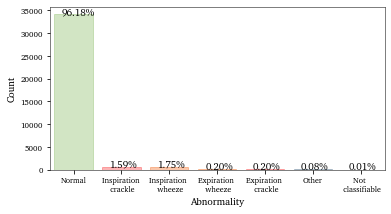

In [8]:
def without_hue(plot, feature, filename):
    total = len(feature)
    
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height() + 5
        ax.annotate(percentage, (x, y), fontproperties = font)
    
    plt.savefig(filename, bbox_inches='tight')
    
    
f, ax = plt.subplots(1,1)
f.set_size_inches(6, 3)
ax = sns.countplot(x = 'label', data = data)
ax.set_ylabel('Count', fontproperties = font)
ax.set_xlabel('Abnormality', fontproperties = font)
for label in ax.get_yticklabels() :
    label.set_fontproperties(font_small)
for label in ax.get_xticklabels() :
    label.set_fontproperties(font_small)
    #name = label.get_text()
    #new_label = str(new_names[name])
    #new_labels.append(new_label)

ax.set_xticklabels(['Normal', 'Inspiration \n crackle', 'Inspiration \n wheeze',
                   'Expiration \n wheeze', 'Expiration \n crackle', 'Other', 'Not \n classifiable'])
#ax.grid(linewidth = 0.3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
count = 0
for child in ax.get_children():
    if type(child) == matplotlib.patches.Rectangle:
        count = count + 1
        
        if (count == 1):
            child.set_color(colors_opa[1])
        elif (count == 2) or (count == 5):
            child.set_color(colors_opa[0])
        elif (count == 3) or (count == 4):
            child.set_color(colors_opa[3])
        elif (count == 6):
            child.set_color(colors_opa[2])
        elif (count == 7):
            child.set_color(colors_opa[5])
        '''
        if (count == 1):
            child.set_color(colors[1])
        elif (count == 2) or (count == 5):
            child.set_color(colors[0])
        elif (count == 3) or (count == 4):
            child.set_color(colors[3])
        elif (count == 6):
            child.set_color(colors[2])
        elif (count == 7):
            child.set_color(colors[5])
        '''
without_hue(ax,data.label , figure_path + "histoLabels.pdf" )  

## Using RMS to compress

In [58]:
file_splits = {
    '/data/ts_files/UiT_5s_noOverlap_TRAIN.ts' : indices_train,
    '/data/ts_files/UiT_5s_noOverlap_TEST.ts' : indices_test,
    '/data/ts_files/UiT_5s_noOverlap_VAL.ts' : indices_val
}

frame_len = round(4000*0.002)
print(f'Frame length for calculating rmf: {frame_len}')
hop_len = ceil(frame_len/1.5)
print(f'Hop length for calculating rmf: {hop_len}')


def write_feature_extracted_dataset_to_ts(filename, data, frac):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName UiT lung sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal exp_crackle exp_wheeze insp_crackle insp_wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for row in data.iterrows():
        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000
            audio = znorm(audio)
            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            sub_audio = get_sub_audios_no_overlap(audio, frac)
            for sub in sub_audio: 
                #rms_sub = librosa.feature.rms(sub, frame_length = frame_len, hop_length = hop_len)[0]
                #print(len(rms_sub))
                #if len(rms_sub)> 3350:
                #    print('here')
                #    continue
                #rms_sub = zero_pad(sub, 20000)
                #new_row = str(list(rms_sub))[1:-1].replace(' ', '') + ':' + label + '\n'
                #w.write(new_row)       
                sub = zero_pad(sub, 25000)
                new_row = str(list(sub))[1:-1].replace(' ', '') + ':' + label + '\n'
                w.write(new_row)
            count = count + 1
            #print(f'Extracting file : {count}, of totally {len(data)}')    
            
            #break
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
            
'''
frac = 3 --> 5 seconds
frac = 5 --> 3 seconds

'''            
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, new_dataset.iloc[i],3)

Frame length for calculating rmf: 8
Hop length for calculating rmf: 6
